In [226]:
import os
import cv2

In [227]:
import numpy as np
import matplotlib.pyplot as plt

In [228]:
DATADIR="G:/Breast_Cancer_dataset"
CATEGORIES=["Cancer","Normal"]

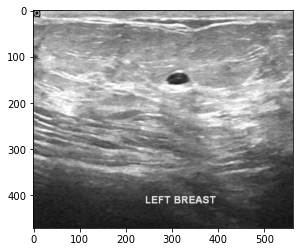

In [229]:
for category in CATEGORIES:
    path=os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        plt.imshow(img_array,cmap="gray")
        plt.show()
        break
    break

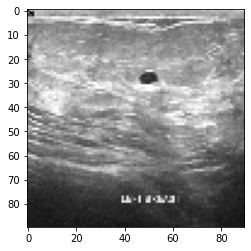

In [230]:
IMG_SIZE=90
new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_array,cmap="gray")
plt.show()

0
1
0


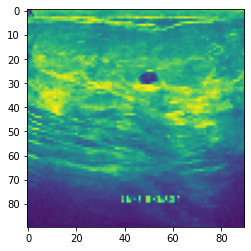

0


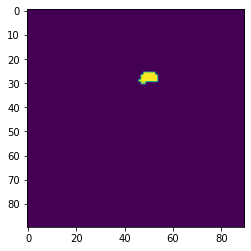

0


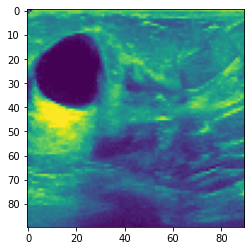

0


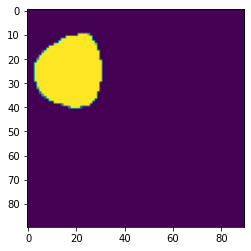

0


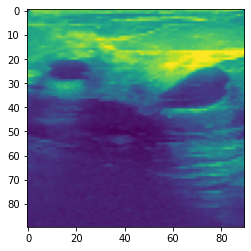

0


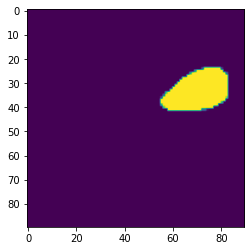

0


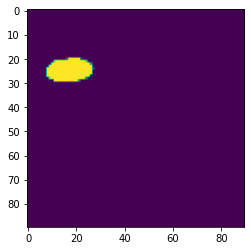

0


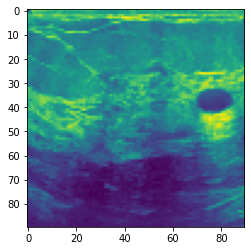

0


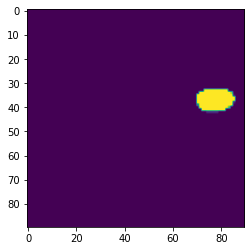

0


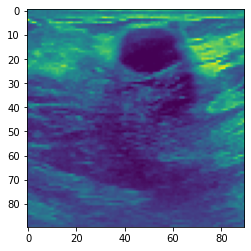

In [231]:
training_data=[]
median_filter1=[]
def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR,category)
        class_num=CATEGORIES.index(category)
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                img1=np.array(img_array)
                median_filter=cv2.medianBlur(img1,5)
                median_resize=cv2.resize(median_filter,(IMG_SIZE,IMG_SIZE))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
                median_filter1.append([median_resize,class_num])
                
            except Exception as e:
                pass
            
                pass
create_training_data()
for sample in median_filter1[ :10]:
    print(sample[1])
    plt.imshow(sample[0])
    plt.show()


In [232]:
import random
random.shuffle(training_data)

0


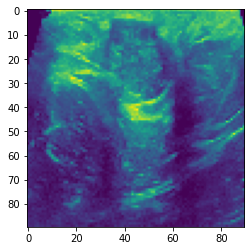

1


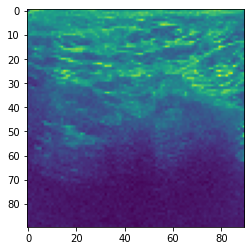

0


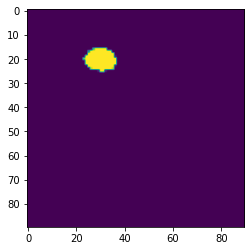

0


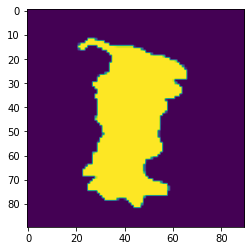

0


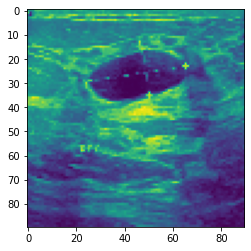

0


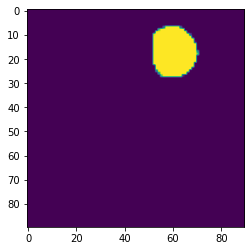

0


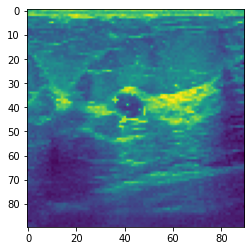

0


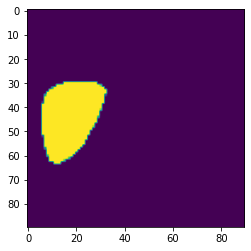

0


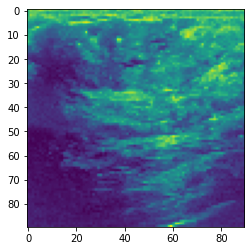

0


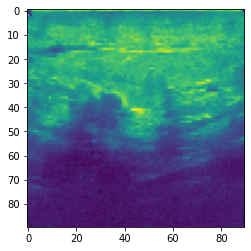

In [233]:
for sample in training_data[ :10]:
    print(sample[1])
    plt.imshow(sample[0])
    plt.show()

In [243]:
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical

In [234]:
X=[]
y=[]
for features,labels in median_filter1:
    X.append(features)
    y.append(labels)
X=np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1)
y=np.array(y).reshape(-1,1)

print(X.shape)
print(y.shape)

(1578, 90, 90, 1)
(1578, 1)


In [245]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [249]:
def entry_flow(inputs) :

    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x

    for size in [128, 256, 728] :

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

        x = tensorflow.keras.layers.Add()([x, residual])
        previous_block_activation = x

    return x

In [250]:
def middle_flow(x, num_blocks=8) :

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = tensorflow.keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x

    return x

In [251]:
def exit_flow(x) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x) 
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = tensorflow.keras.layers.Add()([x, residual])

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='linear')(x)

    return x

In [253]:
inputs = Input(shape=(90,90, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))
xception = Model(inputs, outputs)

In [254]:
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 150

In [257]:
history = xception.fit(X_train, y_train, epochs=8, batch_size=32, validation_data=(X_test, y_test))
xception.save('breast_cancer-model')

Epoch 1/8
45/45 [==============================] - 364s 8s/step - loss: 2.0904e-08 - accuracy: 0.8239 - val_loss: 1.2826e-08 - val_accuracy: 0.8924
Epoch 2/8
45/45 [==============================] - 364s 8s/step - loss: 2.0904e-08 - accuracy: 0.8239 - val_loss: 1.2826e-08 - val_accuracy: 0.8924
Epoch 3/8
45/45 [==============================] - 364s 8s/step - loss: 2.0904e-08 - accuracy: 0.8239 - val_loss: 1.2826e-08 - val_accuracy: 0.8924
Epoch 4/8
45/45 [==============================] - 362s 8s/step - loss: 2.0904e-08 - accuracy: 0.8239 - val_loss: 1.2826e-08 - val_accuracy: 0.8924
Epoch 5/8
45/45 [==============================] - 382s 8s/step - loss: 2.0904e-08 - accuracy: 0.8246 - val_loss: 1.2826e-08 - val_accuracy: 0.8924
Epoch 6/8
45/45 [==============================] - 380s 8s/step - loss: 2.0904e-08 - accuracy: 0.8232 - val_loss: 1.2826e-08 - val_accuracy: 0.8924
Epoch 7/8
45/45 [==============================] - 363s 8s/step - loss: 2.0904e-08 - accuracy: 0.8239 - val_loss

In [235]:
import pickle
pickle_out=open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()


pickle_out=open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

pickle_in=open("X.pickle","rb")
X=pickle.load(pickle_in)


In [242]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D
import pickle
X=pickle.load(open("X.pickle","rb"))
y=pickle.load(open("y.pickle","rb"))
y=np.array(y)
X=X/255.0
#X=X.reshape(-1,90,90,1)
model=Sequential()
model.add(Conv2D(64, (3,3),input_shape=(90,90,1)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(264))
model.add(Activation("relu"))
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dense(1))
model.add(Activation("sigmoid"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])
model.fit(X, y,epochs=6,batch_size=32,validation_split=0.1)
model.save('breast_cancer-model')

Epoch 1/6
45/45 [==============================] - 26s 586ms/step - loss: 0.2425 - accuracy: 0.9099 - val_loss: 1.4023 - val_accuracy: 0.0000e+00
Epoch 2/6
 8/45 [====>.........................] - ETA: 18s - loss: 0.1320 - accuracy: 0.9492

KeyboardInterrupt: 

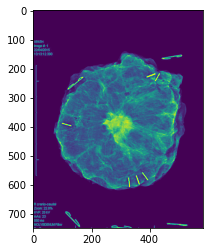

[[-0.07261904]]
There is chances of cancer


In [269]:
import cv2
import tensorflow 
CATEGORIES=["Cancer","Normal"]
def prepare(filepath):
    img_array=cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
    #filtered=cv2.medianBlur(img_array,5)
    plt.imshow(img_array)
    plt.show()
    resized=cv2.resize(img_array,(90,90))
    return resized.reshape(-1,90,90,1)
xception=tf.keras.models.load_model("breast_cancer-model")


prediction = xception.predict([prepare("G:/TRAINING_EXAMPLE/breast_can3.jpg")])
print(prediction)
if(prediction[0] <-0.8):
    print("There is no chances of cancer")
elif(prediction[0]>-0.4):
    print("There is chances of cancer")
#print(CATEGORIES[int(prediction[0][0])])
    